In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt 
import fitsio
import scipy as sp
import scipy.ndimage
from keplersmear.smear_tools import *
from SuzPyUtils.filter import *
from astropy.table import Table, join

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


In [196]:
fname_spc = 'spc_giants.csv'
fname_guy = 'guy_numax.csv'

In [197]:
spc_data = Table.read(fname_spc,format='ascii')

guy_data = Table.read(fname_guy,format='ascii')
print guy_data.keys()

['Object', 'Numax', 'Numax_err', 'White']


In [198]:
guy_data.sort('Object')
spc_data.sort('Object')

In [206]:
numax_sun = 3160.
numax_sun_err = 10.

Teff_sun = 5777.
logg_sun = 4.43812

In [207]:
mapping = np.array([np.where(guy_data['Object'][:]==obj)[0][0] for obj in spc_data['Object'] if (obj in guy_data['Object'])])
missing = np.array([obj not in guy_data['Object'] for obj in spc_data['Object']])

In [208]:
# new_table = join(guy_data[mapping],spc_data[~missing])
new_table = join(guy_data,spc_data)

In [209]:
new_table.keys()

['Object',
 'Numax',
 'Numax_err',
 'White',
 'BJD_TDB',
 'RV',
 'RVerr',
 'Teff',
 'Teff_err',
 'logg',
 'logg_err',
 'monh',
 'monh_err',
 'vsini',
 'vsini_err',
 'CCF',
 'SNRe',
 'n_aps',
 'exptime',
 'spectro',
 'res',
 'method']

In [230]:
g = ((new_table['Teff']/Teff_sun)**0.5) * (new_table['Numax']/numax_sun)
log_g = np.log10(g)+logg_sun

In [228]:
new_table['logg']

2.064
2.995
2.031
2.025
2.074
2.106
1.973
2.06
2.962
2.935
2.877


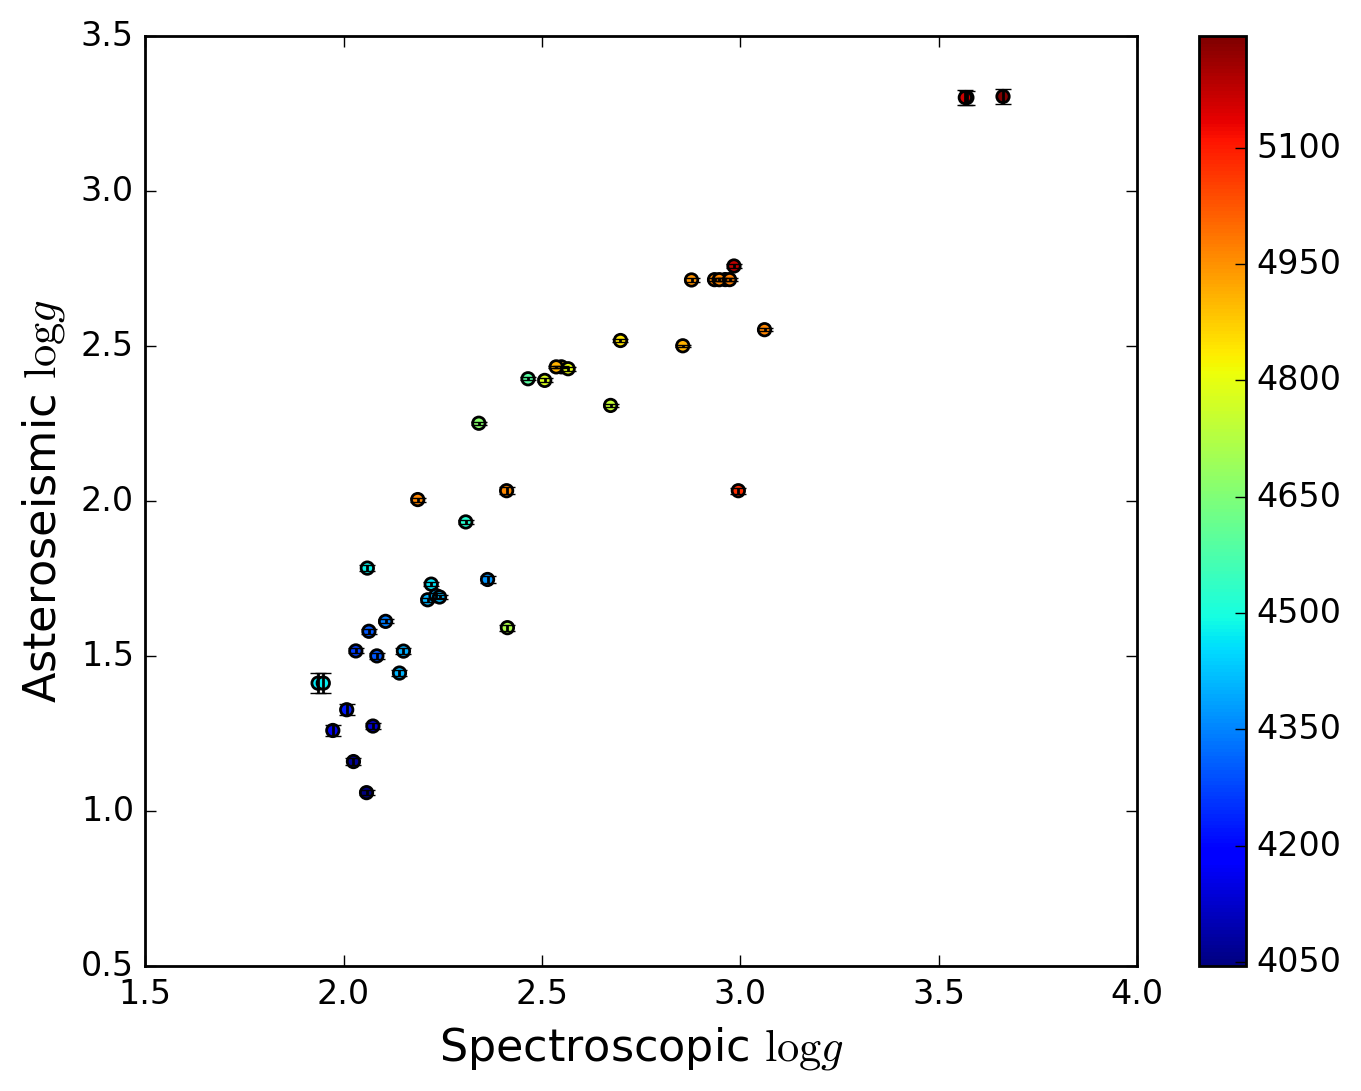

In [257]:
plt.scatter(new_table['logg'],log_g,c=new_table['Teff'])
plt.errorbar(new_table['logg'],log_g,yerr=log_g_err,linestyle='',color='k')
plt.colorbar()
plt.xlabel(r'Spectroscopic $\log{g}$')
plt.ylabel(r'Asteroseismic $\log{g}$')
plt.savefig('numax_correlation.png')

## Now we do it with MCMC

In [244]:
teffs = new_table['Teff'] 
numaxes = new_table['Numax']
numax_errs = new_table['Numax_err']
N = len(teffs)

# data = dict(teff=teffs,mu_numax=numaxes,sig_numax=numax_errs,numax_sun=numax_sun,teff_sun=Teff_sun,N=N)

In [247]:
log_g = []
log_g_err = []

for j in range(N):
    thisnumax = numax_errs[j]*np.random.randn(10000)+numaxes[j]
    thislogg = np.log10((teffs[j]/Teff_sun)**0.5 * (thisnumax/numax_sun))
    log_g.append(np.mean(thislogg))
    log_g_err.append(np.std(thislogg))
    
log_g = np.array(log_g)+logg_sun
log_g_err = np.array(log_g_err)

(array([  7.,   0.,  10.,   4.,   8.,   7.,   1.,   2.,   2.,   2.]),
 array([  13.35681997,   25.78368462,   38.21054926,   50.6374139 ,
          63.06427855,   75.49114319,   87.91800784,  100.34487248,
         112.77173712,  125.19860177,  137.62546641]),
 <a list of 10 Patch objects>)

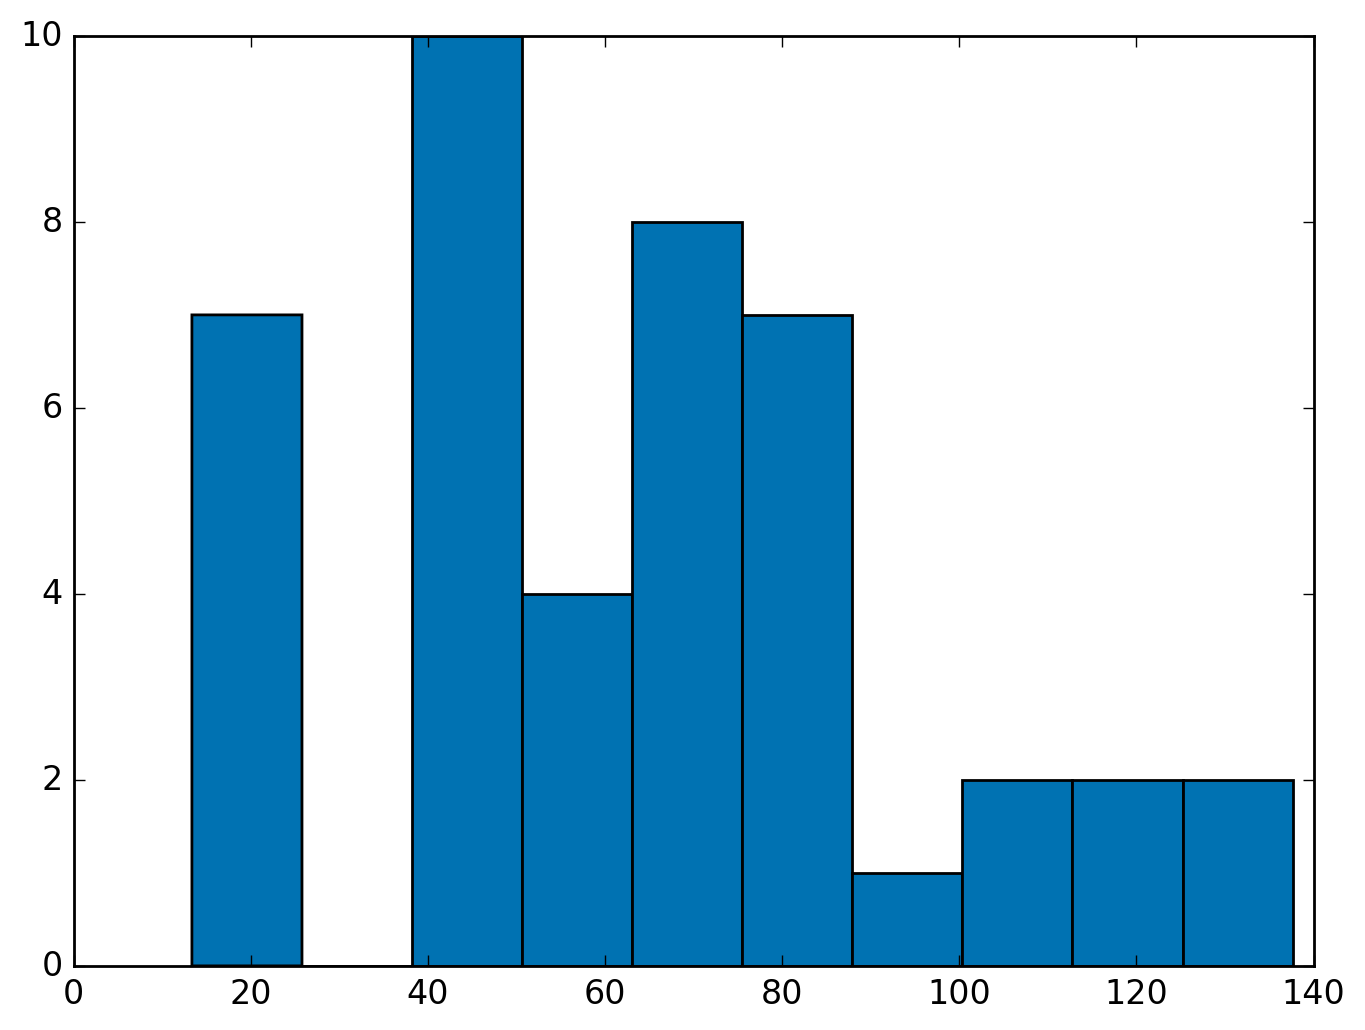

In [256]:
plt.hist(numaxes/numax_errs)

In [259]:
new_table['Object']

BD+36_3564
BD+39_3577
BD+43_3064
BD+43_3171
BD+43_3213
BD+48_2955
HD_174020
HD_174829
HD_175740
HD_175740
HD_175740


In [265]:
output = Table({'Object':new_table['Object'],
                'numax':numaxes,
                'numax_err':numax_errs,
                'log_g':log_g,
                'log_g_err':log_g_err})
output.write('pope_asteroseismology.csv',format='csv')